In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras import Model
from keras.regularizers import l2
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [15]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Dataset params
num_classes = 10
size = x_train.shape[1]

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    60000 samples
Test set:     10000 samples
Sample dims:  (60000, 28, 28)


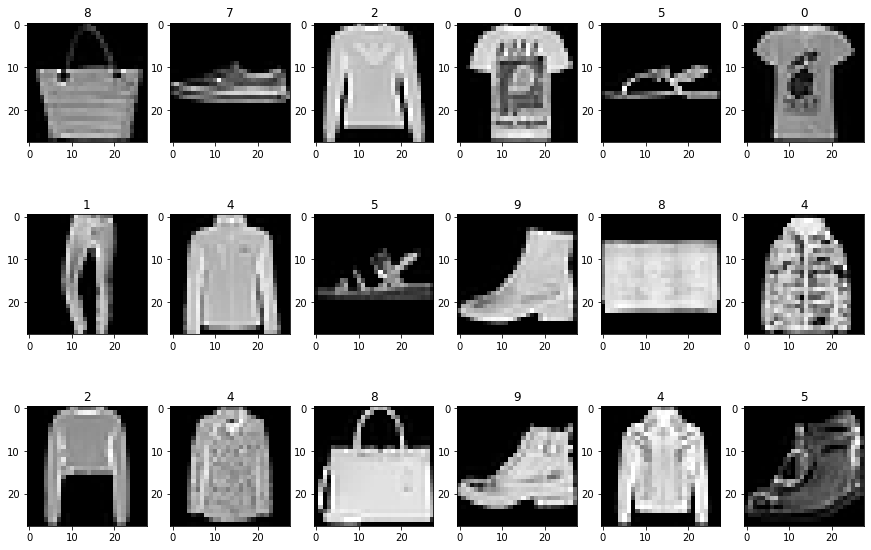

In [3]:
cnt = 1
for r in range(3):
    for c in range(6):
        idx = np.random.randint(len(x_train))
        plt.subplot(3,6,cnt)
        plt.imshow(x_train[idx, ...], cmap='gray')
        plt.title(y_train[idx])
        cnt = cnt + 1

***Building the Classifier***

In [4]:
# Data normalization
x_train = x_train/255
x_test = x_test/255

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,213,002
Trainable params: 3,213,002
Non-trainable params: 0
_________________________________________________________________


2022-11-22 22:07:47.362203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andrew/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-22 22:07:47.362981: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 22:07:47.363590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-11-22 22:07:47.365384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


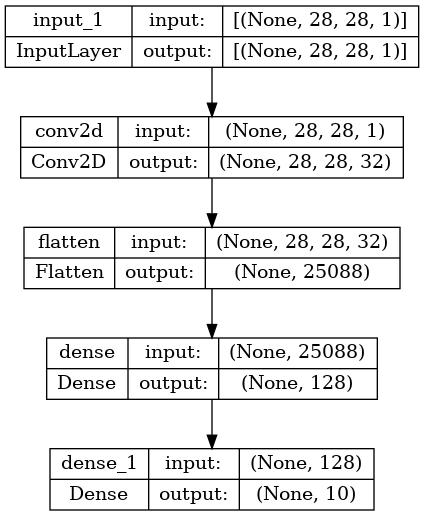

In [5]:
# CNN. Model #1
inputs = Input(shape=(28, 28, 1))
net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
net = Flatten()(net)
net = Dense(128)(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

# Plot the model
tf.keras.utils.plot_model(model, to_file='model.jpg', show_shapes=True, show_layer_names=True)

In [6]:
# Model compilation and training
epochs = 50
batch_size = 64

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

2022-11-22 22:08:00.628724: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/50
936/938 [============================>.] - ETA: 0s - loss: 0.4024 - accuracy: 0.8597

2022-11-22 22:08:28.260006: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


938/938 [==============================] - 27s 28ms/step - loss: 0.4023 - accuracy: 0.8597 - val_loss: 0.3362 - val_accuracy: 0.8805
Epoch 2/50
938/938 [==============================] - 21s 23ms/step - loss: 0.2746 - accuracy: 0.9019 - val_loss: 0.3012 - val_accuracy: 0.8899
Epoch 3/50
938/938 [==============================] - 19s 20ms/step - loss: 0.2330 - accuracy: 0.9145 - val_loss: 0.3009 - val_accuracy: 0.8926
Epoch 4/50
938/938 [==============================] - 17s 18ms/step - loss: 0.2017 - accuracy: 0.9257 - val_loss: 0.2919 - val_accuracy: 0.8997
Epoch 5/50
938/938 [==============================] - 18s 19ms/step - loss: 0.1790 - accuracy: 0.9346 - val_loss: 0.3090 - val_accuracy: 0.8968
Epoch 6/50
938/938 [==============================] - 18s 20ms/step - loss: 0.1598 - accuracy: 0.9411 - val_loss: 0.3084 - val_accuracy: 0.9020
Epoch 7/50
938/938 [==============================] - 18s 19ms/step - loss: 0.1419 - accuracy: 0.9482 - val_loss: 0.3280 - val_accuracy: 0.9009
Epo

Train Acc      0.9948333501815796
Validation Acc 0.8844000101089478


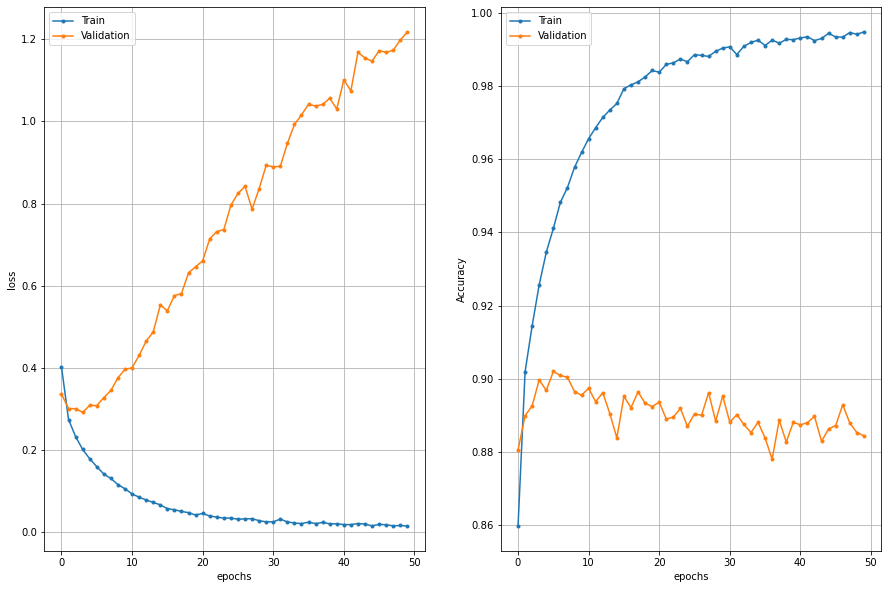

In [7]:
# Show training history
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

***Combat the Overfitting***

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0   

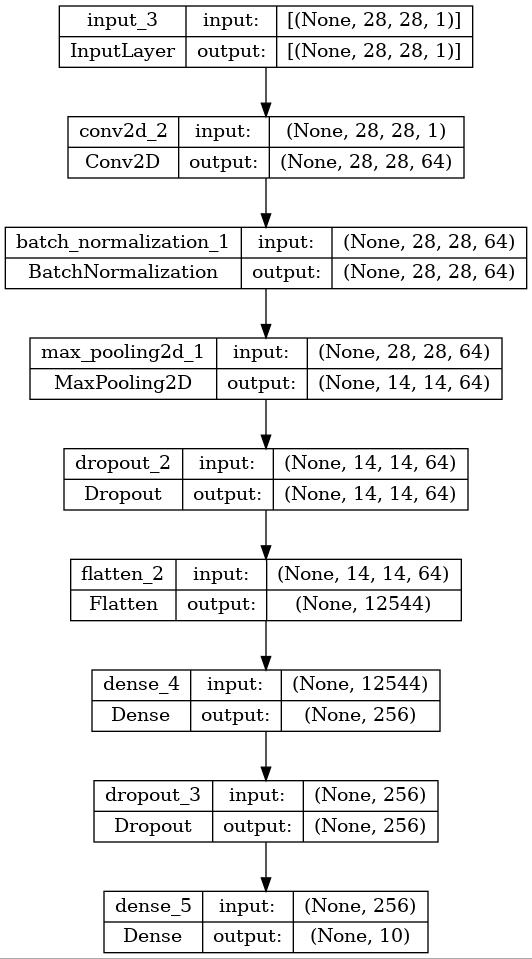

In [16]:
# Modify the baseline classifier in order to reduce the overfitting and make the performance more robust
# CNN. Model #2
inputs = Input(shape=(size, size, 1))

net = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
net = BatchNormalization()(net)
net = MaxPooling2D((2, 2))(net)
#net = SpatialDropout2D(0.2)(net)
net = Dropout(0.2)(net)
net = Flatten()(net)
net = Dense(256, activation='elu', kernel_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))(net)
net = Dropout(0.5)(net)

outputs = Dense(num_classes, activation='softmax')(net)

model = Model(inputs, outputs)
model.summary()

# Plot the model
tf.keras.utils.plot_model(model, to_file='model.jpg', show_shapes=True, show_layer_names=True)

In [17]:
# Train the network
epochs = 50
batch_size = 120

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0.001,
                                            patience=5,
                                            restore_best_weights=True,
                                            verbose=1)

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test),
                    callbacks=[callback])

Epoch 1/50
500/500 [==============================] - 40s 80ms/step - loss: 0.8885 - accuracy: 0.7905 - val_loss: 0.5185 - val_accuracy: 0.8732
Epoch 2/50
500/500 [==============================] - 39s 78ms/step - loss: 0.6114 - accuracy: 0.8485 - val_loss: 0.4946 - val_accuracy: 0.8878
Epoch 3/50
500/500 [==============================] - 40s 79ms/step - loss: 0.5127 - accuracy: 0.8771 - val_loss: 0.4372 - val_accuracy: 0.8995
Epoch 4/50
500/500 [==============================] - 41s 81ms/step - loss: 0.4405 - accuracy: 0.8953 - val_loss: 0.4102 - val_accuracy: 0.9037
Epoch 5/50
500/500 [==============================] - 42s 84ms/step - loss: 0.3907 - accuracy: 0.9078 - val_loss: 0.3758 - val_accuracy: 0.9108
Epoch 6/50
500/500 [==============================] - 42s 83ms/step - loss: 0.3601 - accuracy: 0.9145 - val_loss: 0.3704 - val_accuracy: 0.9091
Epoch 7/50
500/500 [==============================] - 41s 83ms/step - loss: 0.3405 - accuracy: 0.9193 - val_loss: 0.3679 - val_accuracy:

Train Acc      0.9243999719619751
Validation Acc 0.9110999703407288


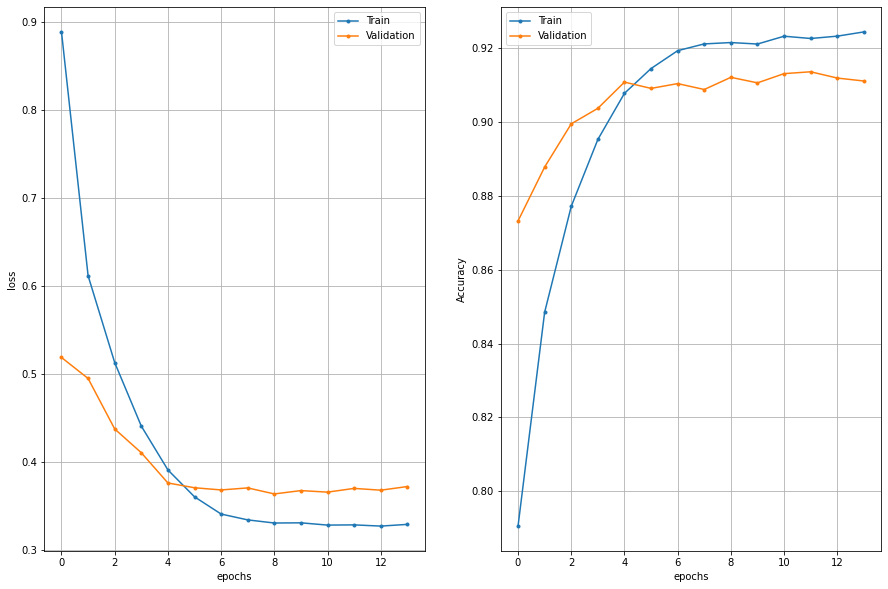

In [18]:
# Show the results
plot_history(history)

In [32]:
# Data augmentation
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  brightness_range=[0.9, 1.1], zoom_range=[0.9, 1.1], horizontal_flip=True)
 
train_generator = data_generator.flow(x_train.reshape(60000, 28, 28, 1), y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
 
history = model.fit(train_generator, validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[callback])


Epoch 1/50
500/500 [==============================] - 50s 98ms/step - loss: 0.4393 - accuracy: 0.8830 - val_loss: 0.3930 - val_accuracy: 0.9073
Epoch 2/50
500/500 [==============================] - 51s 102ms/step - loss: 0.4236 - accuracy: 0.8883 - val_loss: 0.3840 - val_accuracy: 0.9076
Epoch 3/50
500/500 [==============================] - 50s 100ms/step - loss: 0.4213 - accuracy: 0.8867 - val_loss: 0.4076 - val_accuracy: 0.8975
Epoch 4/50
500/500 [==============================] - 51s 101ms/step - loss: 0.4221 - accuracy: 0.8873 - val_loss: 0.3881 - val_accuracy: 0.9052
Epoch 5/50
500/500 [==============================] - 52s 103ms/step - loss: 0.4179 - accuracy: 0.8884 - val_loss: 0.3765 - val_accuracy: 0.9095
Epoch 6/50
500/500 [==============================] - 51s 102ms/step - loss: 0.4197 - accuracy: 0.8885 - val_loss: 0.3900 - val_accuracy: 0.9016
Epoch 7/50
500/500 [==============================] - 48s 96ms/step - loss: 0.4180 - accuracy: 0.8887 - val_loss: 0.3835 - val_accu

Train Acc      0.8892333507537842
Validation Acc 0.9035000205039978


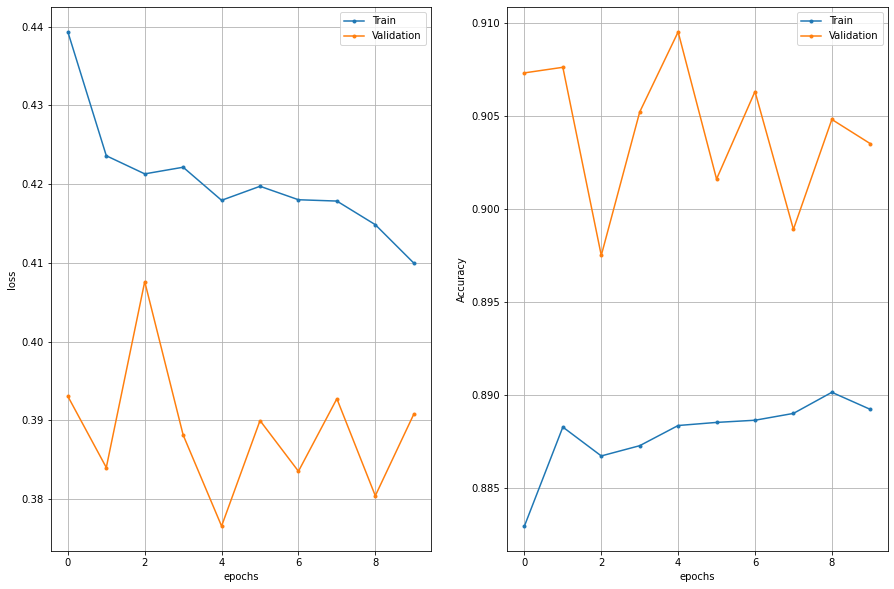

In [33]:
# Show the results
plot_history(history)

***Answers***

To improve performance, I added additional layers that helped overcome overfitting, namely:
* **BatchNormalization** - minimal effect, the network is too small
* **MaxPooling2D** - adding this layer improved the result significantly
* **Dropout** - adding Dropout layers improved the result, but to a lesser extent than MaxPooling2D

And also experimented with regularization and different activation functions.

Data augmentation didn't help in my case, at all. I experimented with random image changes: horizontal flip, brightness change, zoom, inversion. None of this improved the performance of the network. I can assume that the input data is quite simple, so their changes do not greatly affect the training of the network. For example, most of the objects in the test set are horizontally symmetrical (for example, trousers) and the flip will not help in any way.

From experiments, I can say that the performance of this network is very easy to improve by adding additional convolutional layers, but if I understood the task correctly, this was the limitation.